In [1]:
#!pygmentize code/predictor.py

In [2]:
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
#model = BertModel.from_pretrained('bert-base-uncased')
#tokenizer.save_pretrained('./bert-base-uncased-saved/')
#model.save_pretrained('./bert-base-uncased-saved/')
#!(cd bert-base-uncased-saved ; tar -czvf bert-base-uncased-saved.tar.gz *)
#!(cd bert-base-uncased-saved ; aws s3 cp bert-base-uncased-saved.tar.gz s3://inf1-compiled-model/)

In [3]:
#!aws s3 ls s3://inf1-compiled-model/bert-base-uncased-saved.tar.gz

In [4]:
#!aws s3 cp s3://inf1-compiled-model/bert-base-uncased-saved.tar.gz . 

In [5]:
#!mkdir bert-base-uncased-saved
#!(cd bert-base-uncased-saved ; tar -xzvf ../bert-base-uncased-saved.tar.gz) 

In [6]:
#!cat Dockerfile.sm.neuron-rtd

In [7]:
!ls

bert-base-uncased-saved		Dockerfile.sm.neuron-rtd  README.md
bert-base-uncased-saved.tar.gz	inf1-container.ipynb
code				inference.py


In [8]:
%%sh 

# The name of our algorithm
algorithm_name=chazarey-inf1-serving
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR

docker build -t ${algorithm_name} -f Dockerfile.sm.neuron-rtd .
docker tag ${algorithm_name} ${fullname}
docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  843.6MB
Step 1/22 : FROM amazonlinux:2
 ---> ba2cc467a2bc
Step 2/22 : MAINTAINER Chaitanya Hazarey <chazarey@amazon.com>
 ---> Using cache
 ---> 088a31d5941a
Step 3/22 : RUN echo $'[neuron] \nname=Neuron YUM Repository \nbaseurl=https://yum.repos.neuron.amazonaws.com \nenabled=1' > /etc/yum.repos.d/neuron.repo
 ---> Using cache
 ---> 0769d0beed1b
Step 4/22 : RUN rpm --import https://yum.repos.neuron.amazonaws.com/GPG-PUB-KEY-AMAZON-AWS-NEURON.PUB
 ---> Using cache
 ---> 5eae2d75e8f3
Step 5/22 : RUN yum install -y wget
 ---> Using cache
 ---> dfd9fed5d8f0
Step 6/22 : RUN yum install -y aws-neuron-tools
 ---> Using cache
 ---> 276a5f678a9e
Step 7/22 : RUN yum install -y aws-neuron-runtime
 ---> Using cache
 ---> 1fd9585a3950
Step 8/22 : RUN yum install -y tar gzip ca-certificates procps net-tools which vim
 ---> Using cache
 ---> 43815f81991a
Step 9/22 : RUN amazon-linux-extras install -y nginx1
 ---> Using cache
 ---> d3b2f457d5e9


WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [9]:
#!pip install 'sagemaker[local]' --upgrade

In [10]:
%%time

import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import csv_serializer

role = sagemaker.session.get_execution_role()

model_data='s3://inf1-compiled-model/model.tar.gz'

pytorch_model = PyTorchModel(model_data=model_data, 
                             role=role,
                             entry_point='inference.py',
                             image='111652037296.dkr.ecr.us-east-1.amazonaws.com/chazarey-inf1-serving:latest',
                             framework_version='1.5.0',
                             enable_cloudwatch_metrics=True)

predictor = pytorch_model.deploy(instance_type='ml.inf1.xlarge', initial_instance_count=1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Your model is not compiled. Please compile your model before using Inferentia.


---------------!CPU times: user 18.7 s, sys: 2.75 s, total: 21.4 s
Wall time: 8min 9s


In [11]:
print(predictor.endpoint)

chazarey-inf1-serving-2020-09-14-16-14-23-416


In [12]:
!pip install transformers

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [13]:
import random
import torch
import transformers
from transformers import BertTokenizer
from transformers import BertModel
import math
import numpy as np
import io
from sagemaker.predictor import json_serializer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle 
import json

def random_sentence():
    
    s_nouns = ["A dude", "My mom", "The king", "Some guy", "A cat with rabies", "A sloth", "Your homie", "This cool guy my gardener met yesterday", "Superman"]
    p_nouns = ["These dudes", "Both of my moms", "All the kings of the world", "Some guys", "All of a cattery's cats", "The multitude of sloths living under your bed", "Your homies", "Like, these, like, all these people", "Supermen"]
    s_verbs = ["eats", "kicks", "gives", "treats", "meets with", "creates", "hacks", "configures", "spies on", "retards", "meows on", "flees from", "tries to automate", "explodes"]
    p_verbs = ["eat", "kick", "give", "treat", "meet with", "create", "hack", "configure", "spy on", "retard", "meow on", "flee from", "try to automate", "explode"]
    infinitives = ["to make a pie.", "for no apparent reason.", "because the sky is green.", "for a disease.", "to be able to make toast explode.", "to know more about archeology."]
    
    return (random.choice(s_nouns) + ' ' + random.choice(s_verbs) + ' ' + random.choice(s_nouns).lower() or random.choice(p_nouns).lower() + ' ' + random.choice(infinitives))

print(random_sentence())


A dude retards superman


In [16]:
predictor.accept = 'application/json'
predictor.content_type = 'application/json'
predictor.serializer = json_serializer
predictor.deserializer = None


input_data = {}
input_data['sentence1'] = random_sentence()
input_data['sentence2'] = random_sentence()
json_data = json.dumps(input_data)
embedding_returned = predictor.predict(json_data)
embedding_returned = pickle.loads(embedding_returned)
s1 = embedding_returned[1]
#print(pickle.loads(raw_bytes))


In [17]:
from sagemaker.predictor import json_serializer, json_deserializer
import torch

predictor.accept = 'application/json'
predictor.content_type = 'application/json'
predictor.serializer = json_serializer
predictor.deserializer = None

for i in range(0,10):    
       
    try:
        input_data = {}
        input_data['sentence1'] = random_sentence()
        input_data['sentence2'] = random_sentence()
        json_data = json.dumps(input_data)
        embedding_returned = predictor.predict(json_data)
        embedding_returned = pickle.loads(embedding_returned)
        s1 = embedding_returned[1]
        #print(pickle.loads(raw_bytes))
    except:
        pass
    
    try:
        input_data = {}
        input_data['sentence1'] = random_sentence()
        input_data['sentence2'] = random_sentence()
        json_data = json.dumps(input_data)
        embedding_returned = predictor.predict(json_data)
        embedding_returned = pickle.loads(embedding_returned)
        s2 = embedding_returned[1]
        #print(pickle.loads(raw_bytes))
    except:
        pass    
    
    cos = torch.nn.CosineSimilarity()    
    cos_sim = cos(s1,s2)
    cosine_measure = cos_sim[0].item()
    angle_in_radians = math.acos(cosine_measure)
    print(math.degrees(angle_in_radians))

29.949707011162513
4.988334253443685
1.9931161171446772
13.931057721021311
15.776429377265936
47.09833590631524
15.868477279137611
31.990970602412656
44.92401845753722
7.15963217100164


In [18]:
import numpy as np 
import datetime
import math
import time
import boto3   
import matplotlib.pyplot as plt


endpoint_name=predictor.endpoint
total_runs=1000

In [19]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'
predictor.serializer = json_serializer
predictor.deserializer = None

print('Running {} inferences for {}:'.format(total_runs, endpoint_name))

client_times = []
errors_list = []
cw_start = datetime.datetime.utcnow()

errors = 0

for i in range(total_runs):    
    
    client_start = time.time()
    
    try:
        input_data = {}
        input_data['sentence1'] = random_sentence()
        input_data['sentence2'] = random_sentence()
        json_data = json.dumps(input_data)
        embedding_returned = predictor.predict(json_data)
        embedding_returned = pickle.loads(embedding_returned)
        s1 = embedding_returned[1]
        errors_list.append(20)
    except:
        errors += 1
        errors_list.append(30)
        pass
    
    client_end = time.time()
    client_times.append((client_end - client_start)*1000)
    
print('\nErrors - {:.4f} out of {:.4f} total runs | {:.4f}% \n'.format(errors, total_runs, (errors/total_runs)*100))
errors = 0
    
    
cw_end = datetime.datetime.utcnow()    
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))

print('Getting Cloudwatch:')
cloudwatch = boto3.client('cloudwatch')
statistics=['SampleCount', 'Average', 'Minimum', 'Maximum']
extended=['p50', 'p90', 'p95', 'p100']

# Give 5 minute buffer to end
cw_end += datetime.timedelta(minutes=5)

# Period must be 1, 5, 10, 30, or multiple of 60
# Calculate closest multiple of 60 to the total elapsed time
factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
period = factor * 60
print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
print('Using period of {} seconds\n'.format(period))

cloudwatch_ready = False
# Keep polling CloudWatch metrics until datapoints are available
while not cloudwatch_ready:
  time.sleep(30)
  print('Waiting 30 seconds ...')
  # Must use default units of microseconds
  model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='ModelLatency',
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )
  # Should be 1000
  if len(model_latency_metrics['Datapoints']) > 0:
    print('{} latency datapoints ready'.format(model_latency_metrics['Datapoints'][0]['SampleCount']))
    side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
    side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
    side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
    side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
    side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs
    print('Avg | P50 | P90 | P95 | P100')
    print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p100))

    cloudwatch_ready = True
    
    #embeddings_returned = pickle.loads(raw_bytes)
    #s1 = embeddings_returned[1]
    #print(pickle.loads(raw_bytes))

Running 1000 inferences for chazarey-inf1-serving-2020-09-14-16-14-23-416:

Errors - 0.0000 out of 1000.0000 total runs | 0.0000% 

Client end-to-end latency percentiles:
Avg | P50 | P90 | P95 | P100
20.5206 | 20.1850 | 22.1897 | 23.1107

Getting Cloudwatch:
Time elapsed: 320.524736 seconds
Using period of 360 seconds

Waiting 30 seconds ...
627.0 latency datapoints ready
Avg | P50 | P90 | P95 | P100
26.9307 | 11.0015 | 12.1737 | 12.5028



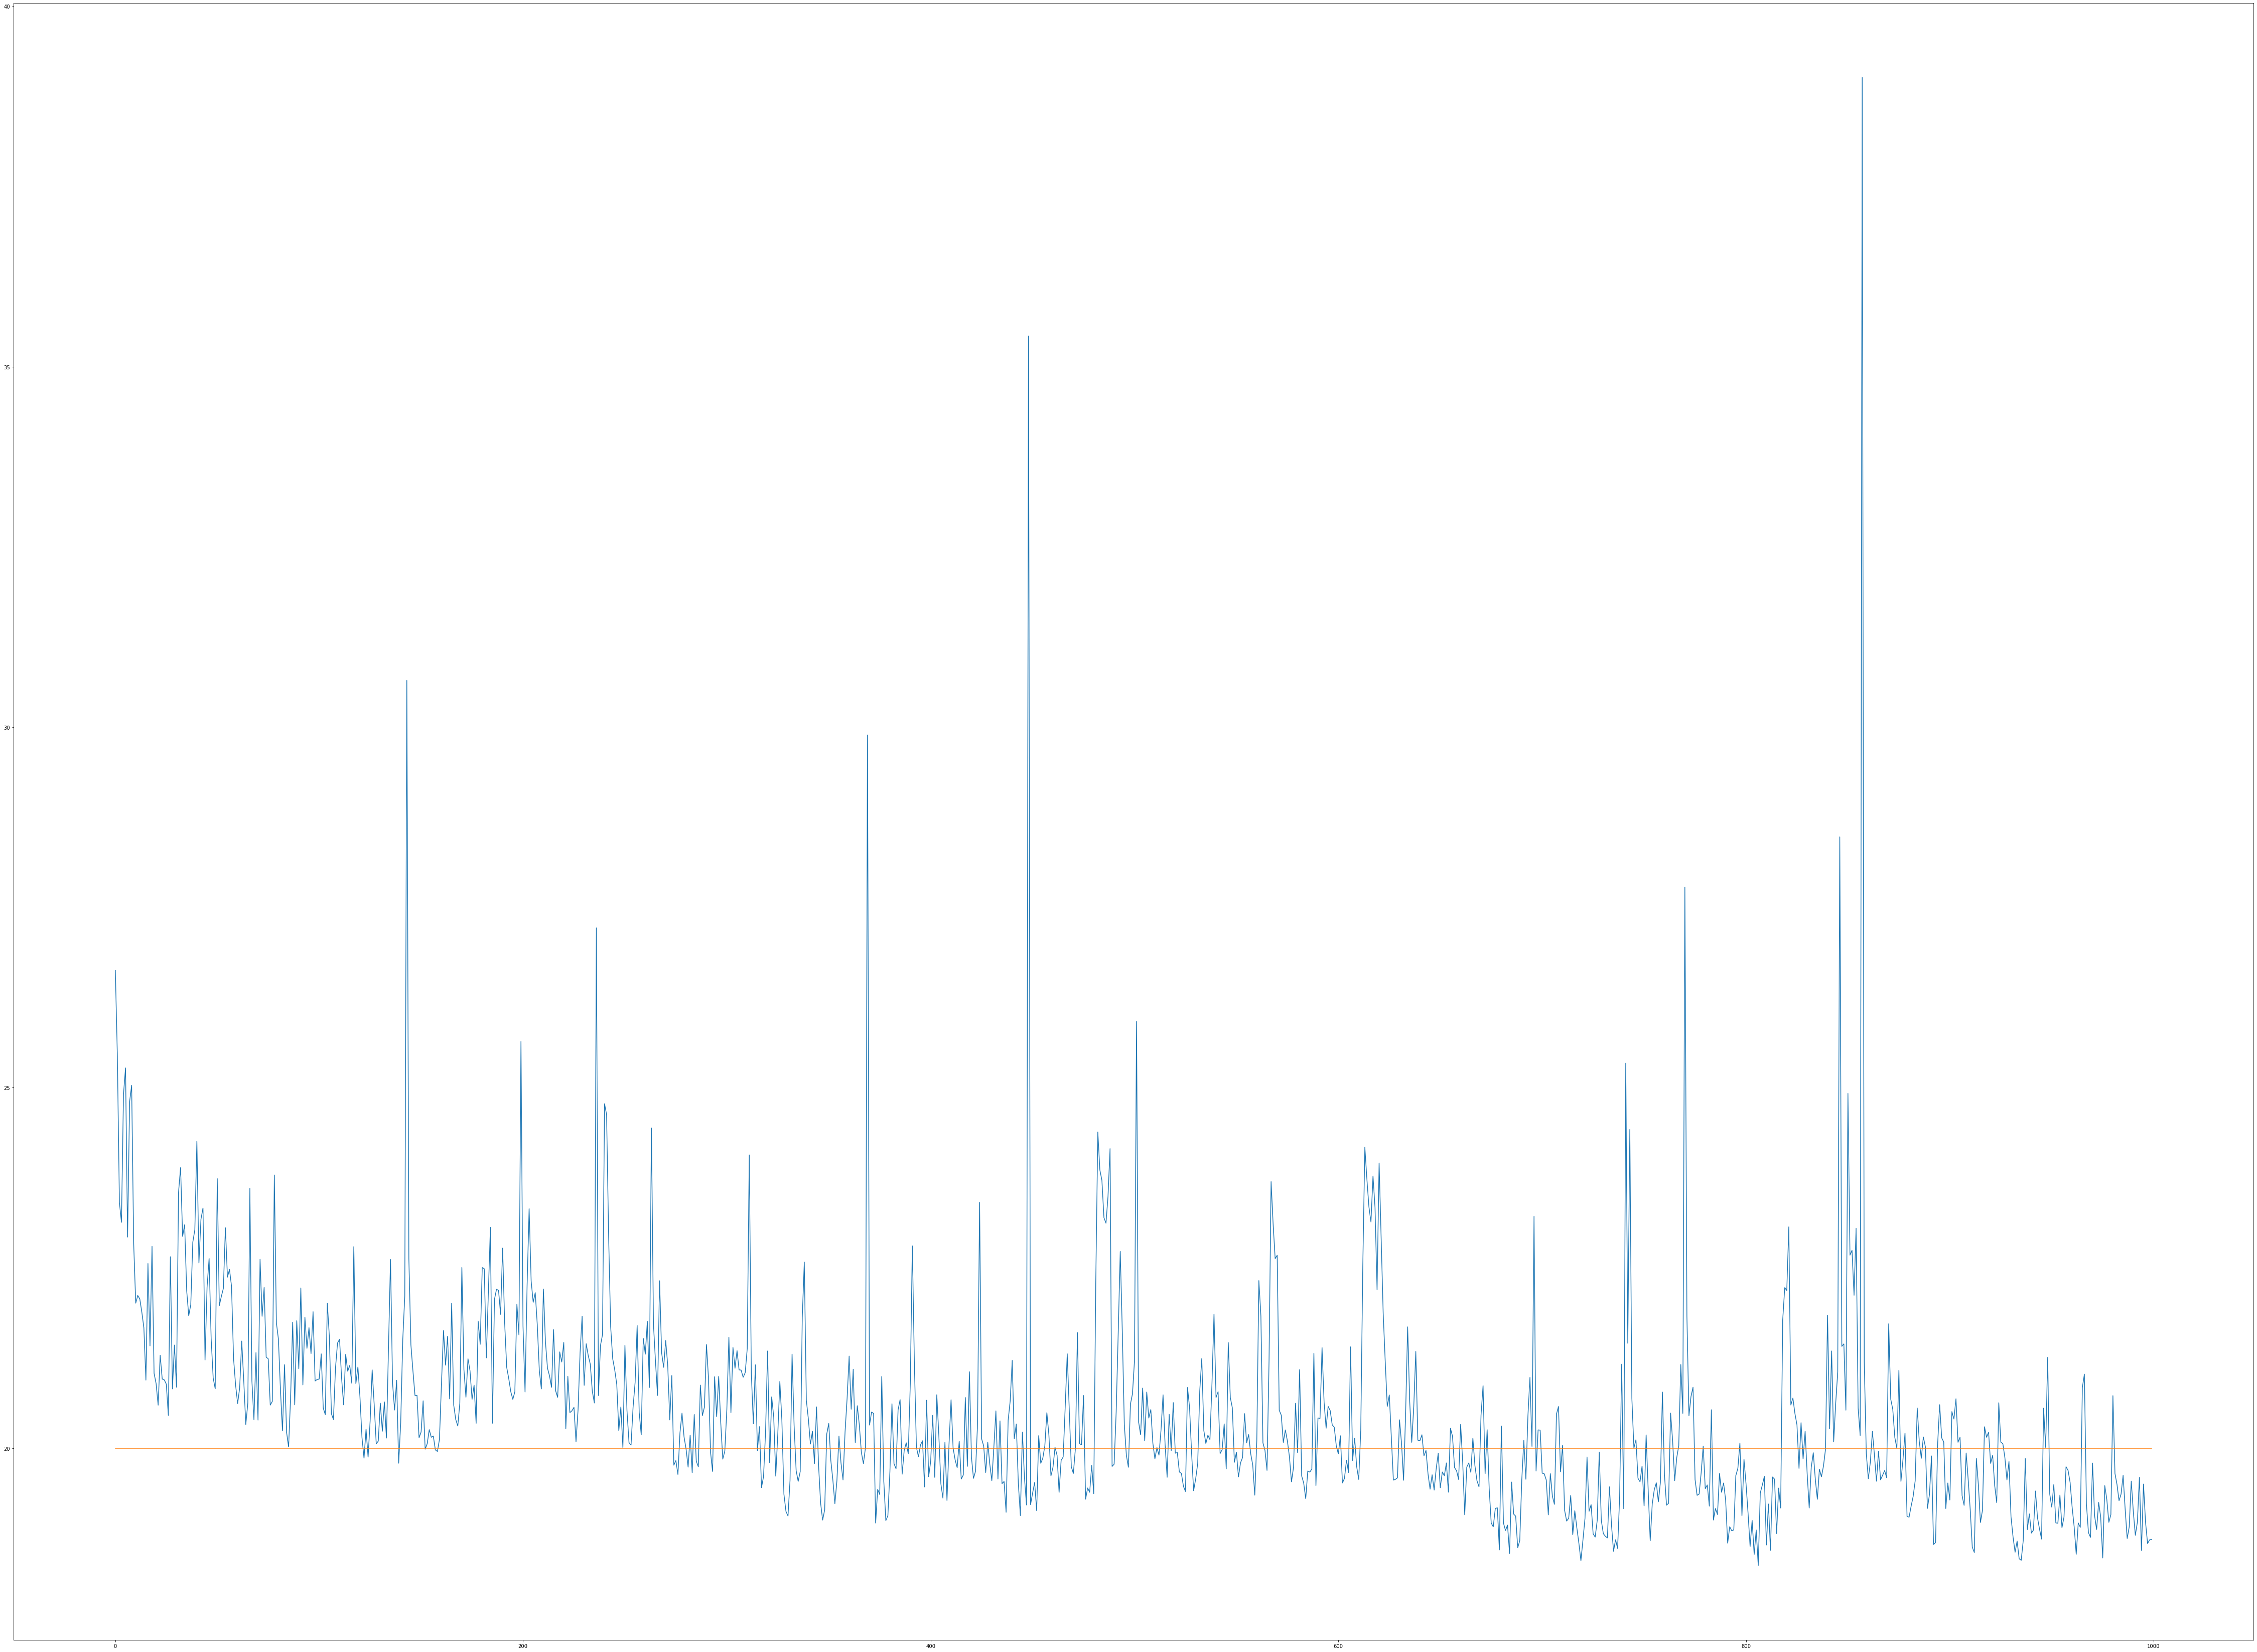

In [20]:
fig = plt.figure(figsize=(80, 60))
ax = fig.add_subplot(111)
ax.plot(client_times)
ax.plot(errors_list)

In [ ]:
#client_times

In [ ]:
c = '''client_times = []
cw_start = datetime.datetime.utcnow()

client_start = time.time()

time.sleep(1)

client_end = time.time()

client_times.append((client_end - client_start))

cw_end = datetime.datetime.utcnow()    
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))
'''